# **Kevin Ryan - DS601P**


# 1.0 Introduction

## Task

I was tasked with analyzing a given set of data for a Recipe Site and developing a model to predict popular recipes that result in high traffic, to be featured on the website. Additionally, I was to create a written report (this document) to summarize the analysis I performed and my findings, and an overview presentation of my work. 

## Conditions

I was given a Dataset (recipe_site_traffic_2212.csv) and a series of documents. These documents contained the instructions as well as a "Data Information" sheet, containing the details and characteristics of each variable.  

## Standard

The model must predict which recipes will be popular 80% of the time and minimize the chance of showing unpopular recipes. 

## Method 

My method was to follow the generally accepted practice of cleaning the data, analyzing and understanding the data, developing models and evaluating their performance, defining a business metric, and then delivering recommendations.   

● Data validation:<br>
> ○ Describe validation and cleaning steps for every column in the data<br>

● Exploratory Analysis to answer the customer questions ensuring you include:<br>
> ○ Two different types of graphic showing single variables only<br>
> ○ At least one graphic showing two or more variables<br>
> ○ Description of your findings<br>

● Model Development including:<br>
> ○ What type of problem this is<br>
> ○ Fitting a baseline model<br>
> ○ Fitting a comparison model<br>

● Model evaluation<br>
> ○ Show how the two models compare<br>

● Definition of a metric for the business to monitor<br>
> ○ How should the business monitor what they want to achieve?<br>
> ○ Estimate the initial value(s) for the metric based on the current data?<br>

● Final summary including recommendations that the business should undertake<br>
<br><br>
Each point of performance in the following notebook is marked **in bold text** to simplify validation.



In [41]:
# Loading the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [43]:
# Load the dataset and set Recipe as the Index Column- based on information from the Data Information Sheet
data = pd.read_csv('recipe_site_traffic_2212.csv',index_col='recipe')

# 2.0 Data Validation

### Step 1: Data Inspection
We begin by inspecting the data to gain an initial understanding.   

In [47]:
# Step 1: Inspect the dataset
print("Initial Dataset Overview:\n")
print(data.head())
print("\nDataset Info:\n")
print(data.info())
print("\nDataset Description (Numerical Columns):\n")
print(data.describe())
print("\nDataset Shape):\n")
print(data.shape)
print("\nDataset Types):\n")
print(data.dtypes)

Initial Dataset Overview:

        calories  carbohydrate  sugar  protein   category servings  \
recipe                                                               
1            NaN           NaN    NaN      NaN       Pork        6   
2          35.48         38.56   0.66     0.92     Potato        4   
3         914.28         42.68   3.09     2.88  Breakfast        1   
4          97.03         30.56  38.63     0.02  Beverages        4   
5          27.05          1.85   0.80     0.53  Beverages        4   

       high_traffic  
recipe               
1              High  
2              High  
3               NaN  
4              High  
5               NaN  

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float6

### Step 2: Data Type Validation
The 'calories,' 'carbohydrate,' 'sugar,' and 'protein' columns are a 'numeric' data type, which is appropriate for the exercise. <br>

The 'category,' 'servings,' and 'high_traffic' should be converted to the 'categorical' data type. Although 'servings' is a numeric value up to six, there are only four existing values, and thus it should be treated as a category.  

In [50]:
data['category'] = data['category'].astype('category')
data['high_traffic'] = data['high_traffic'].astype('category')

### Step 3: Data Wrangling
The 'high_traffic' column has only a value of 'High' for instances of high traffic, and a blank entry for other cases. To address this, I replaced the empty values with 'Not_High', and I changed the name to simply 'traffic.' This seems appropriate, since a day that does not meet the threshold for high traffic is not necessarily a day of low traffic, semantically. <br>

Next, I look at the servings column and count the unique values. Some of these have been listed as "# as a snack" rather than the usual number of servings, and I remove that unwanted text with a string-replace. I once again force the variable as a category, since it likely did not work the first time for 'servings.' Lastly I print the new counts for each category (4,6,2,1) and it looks good. 

In [53]:
# Fixing high_traffic 
print(data['high_traffic'].value_counts())
data['high_traffic'] = data['high_traffic'].cat.add_categories('Not_High')
data["high_traffic"] = data["high_traffic"].fillna('Not_High')
data.rename(columns={'high_traffic': 'traffic'}, inplace=True)
print(data['traffic'].value_counts())

high_traffic
High    574
Name: count, dtype: int64
traffic
High        574
Not_High    373
Name: count, dtype: int64


In [55]:
# Fixing servings 
print(data['servings'].value_counts())
data['servings'] = data['servings'].str.replace(' as a snack','')
data['servings'] = data['servings'].astype('category')
print(data['servings'].value_counts())

servings
4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: count, dtype: int64
servings
4    391
6    198
2    183
1    175
Name: count, dtype: int64


### Step 3: Data Cleaning
There are still other issues to be addressed in the dataset. I continue by detecting and dropping any duplicates, then looking for missing values.<br>

For the missing values that exist, we deal with them by creating a backup copy (data_orig) of the dataset before modifications. Next, I drop rows where any of "calories", "carbohydrate", "sugar", or "protein" values are missing. I generate a side-by-side heatmap visualization to compare missing values before and after cleaning and to confirm that we are solid.<br>

Next, I move on to dealing with outliers. I create a backup of the dataset before any modification. I then detect outliers using the Interquartile Range (IQR) method. Rather than exclude them from the dataset, I chose to replace extreme values with upper/lower thresholds.
I applied this method to all numeric columns, in order to ensure consistent outlier treatment.

In [58]:
# Detect and count any duplicates
num_duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 23


In [60]:
# Drop duplicates
data.drop_duplicates(inplace= True)
data.shape

(924, 7)

In [62]:
# Detect and count any missing values
print(data.isna().sum().sort_values())

category         0
servings         0
traffic          0
calories        29
carbohydrate    29
sugar           29
protein         29
dtype: int64


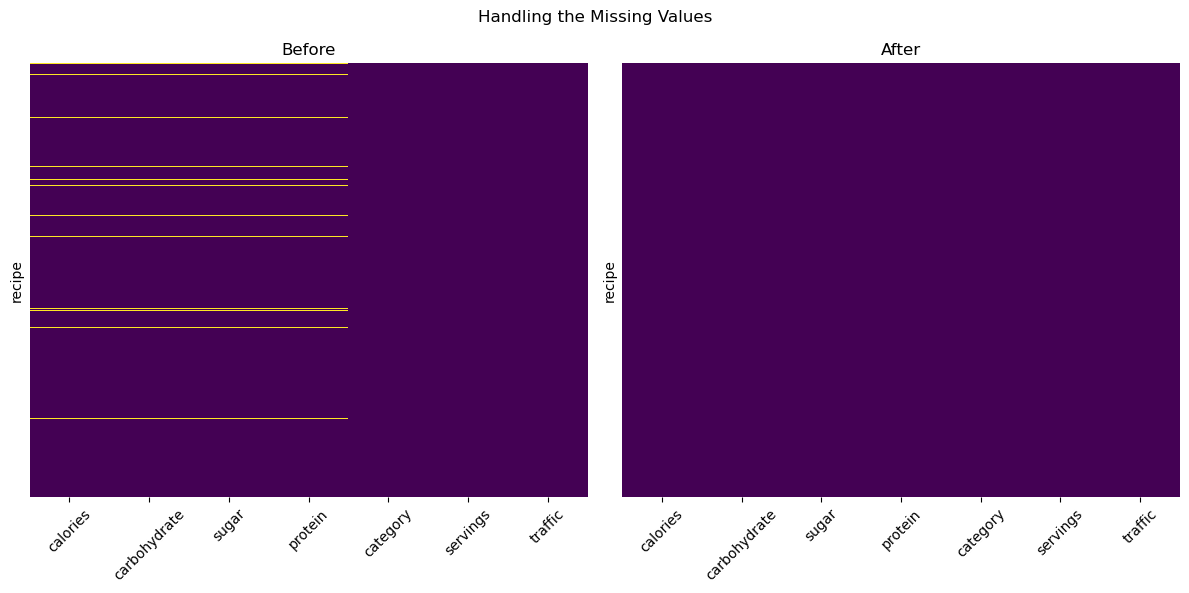

In [64]:
data_orig = data.copy()
data = data.dropna(subset = ['calories','carbohydrate','sugar','protein'])

# To check Missing Values
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(data_orig.isnull(), cbar=False, yticklabels=False, cmap="viridis",ax=axes[0])
sns.heatmap(data.isnull(), cbar=False, yticklabels=False, cmap="viridis", ax=axes[1])
axes[0].set_title("Before")
axes[1].set_title("After")
fig.suptitle("Handling the Missing Values")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
plt.tight_layout()

In [66]:
# create a copy
data_bef =data.copy()

# Handling Outliers
def handle_outlier(df,col):
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    IQR = Q3 - Q1
    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

data_num = data.select_dtypes(include = ["float64", "int64"])

for column in data_num.columns:
    handle_outlier(data, column)

# 3.0 Exploratory Analysis 

### 3.1: Visualization of the Outlier Operation
Next, it is appropriate to confirm that extreme values were adusted or capped properly when conducting the outlier opration above. I generated a boxplot to confirm this while also exploring the effect on the spread of numeric values for the four numeric variables. It is evident from the long whiskers on the top end that the values for each are positively skewed (right skewed) towards the lower end of the spectrum for each variable. 

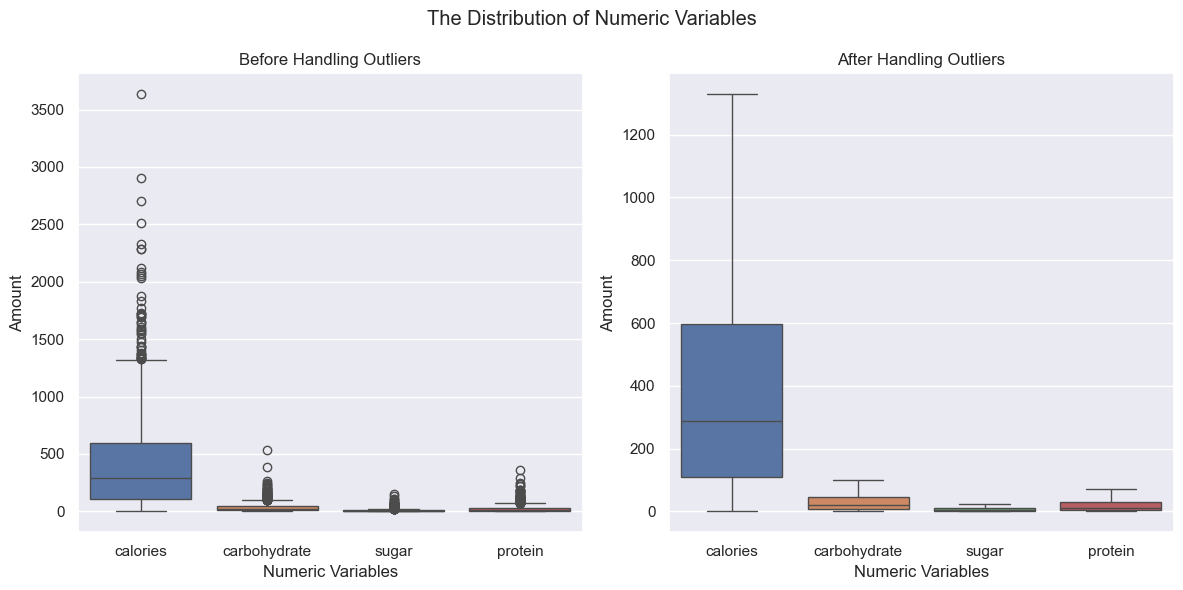

In [40]:
sns.set(style="darkgrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data_bef,ax=axes[0])
sns.boxplot(data,ax=axes[1])
axes[0].set_title("Before Handling Outliers")
axes[1].set_title("After Handling Outliers")
fig.suptitle("The Distribution of Numeric Variables")
axes[0].set_xlabel("Numeric Variables")
axes[1].set_xlabel("Numeric Variables")
axes[0].set_ylabel("Amount")
axes[1].set_ylabel("Amount")
plt.tight_layout()
plt.show()

### 3.1: Visualization of the Outlier Operation, per variable, with Kernel Density Estimation (KDE)
Next, I compared the data distribution before and after handling outliers by variable, using histograms.I also used KDE to better illustrate the shape of the feature changes.<br>

I also calculated the before and after skewness to quantify the effect. The skewness is greatly improved, but we still see each variable as greater than 1, indicating right-skew.

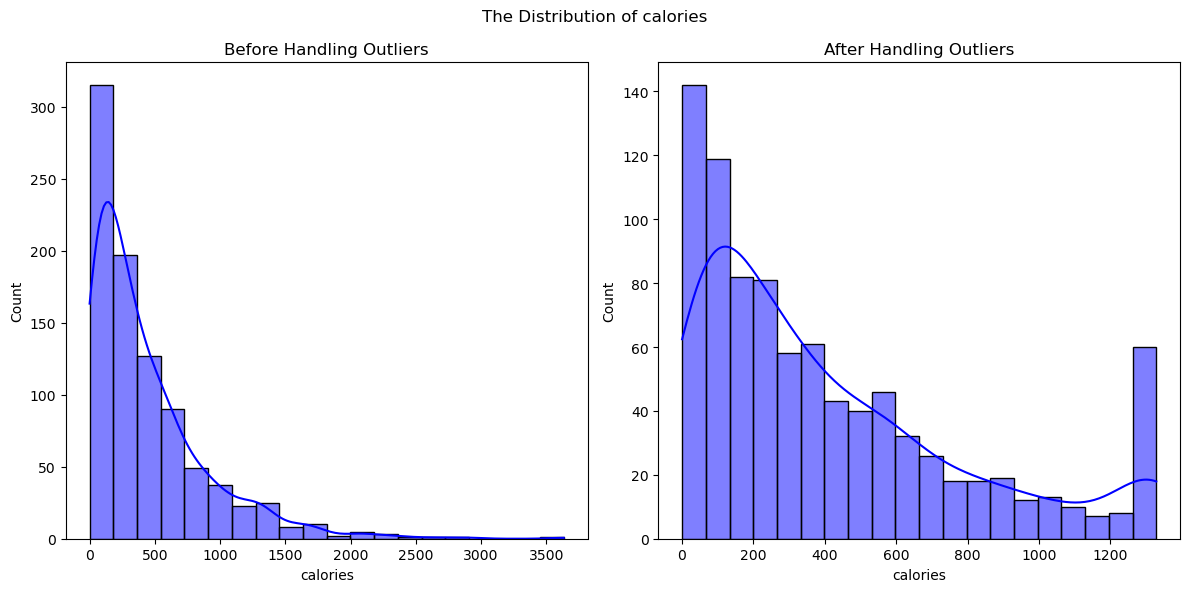

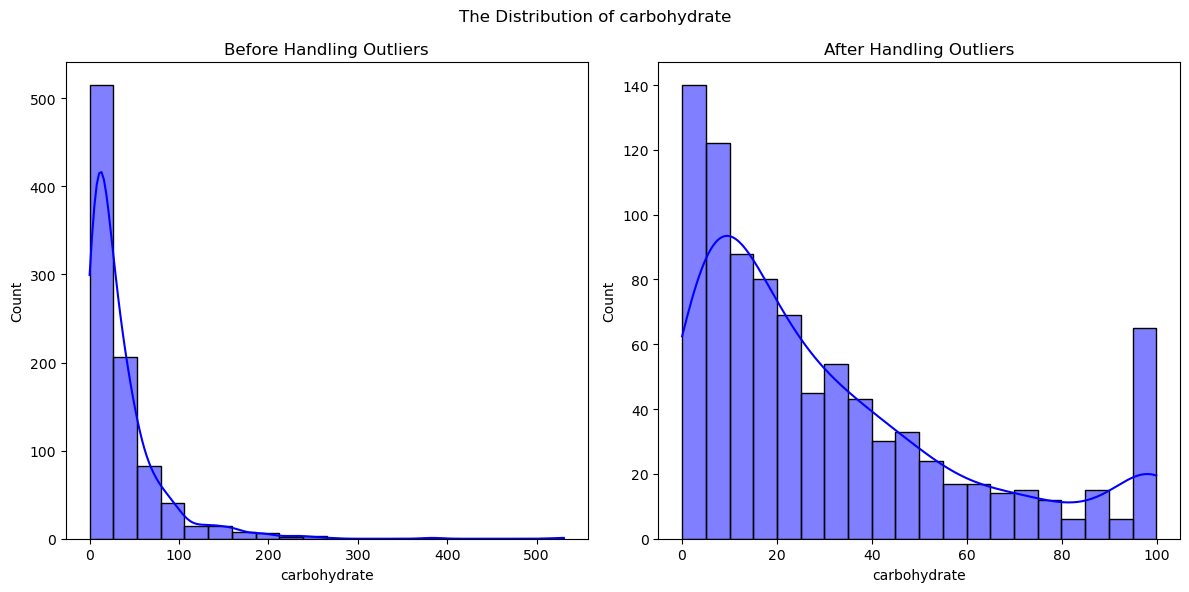

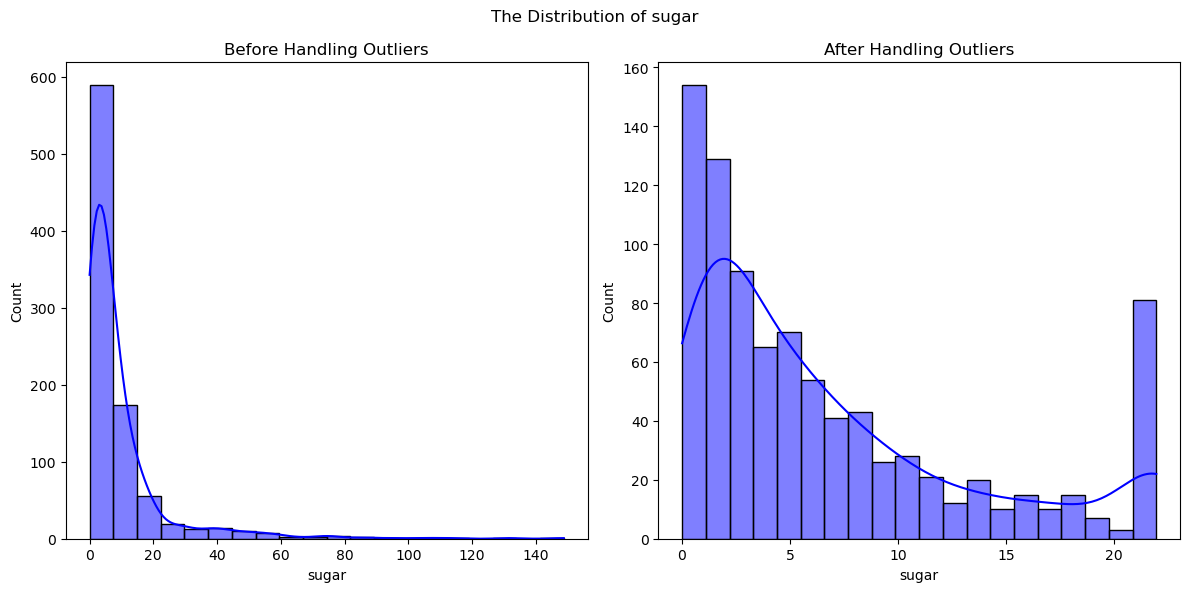

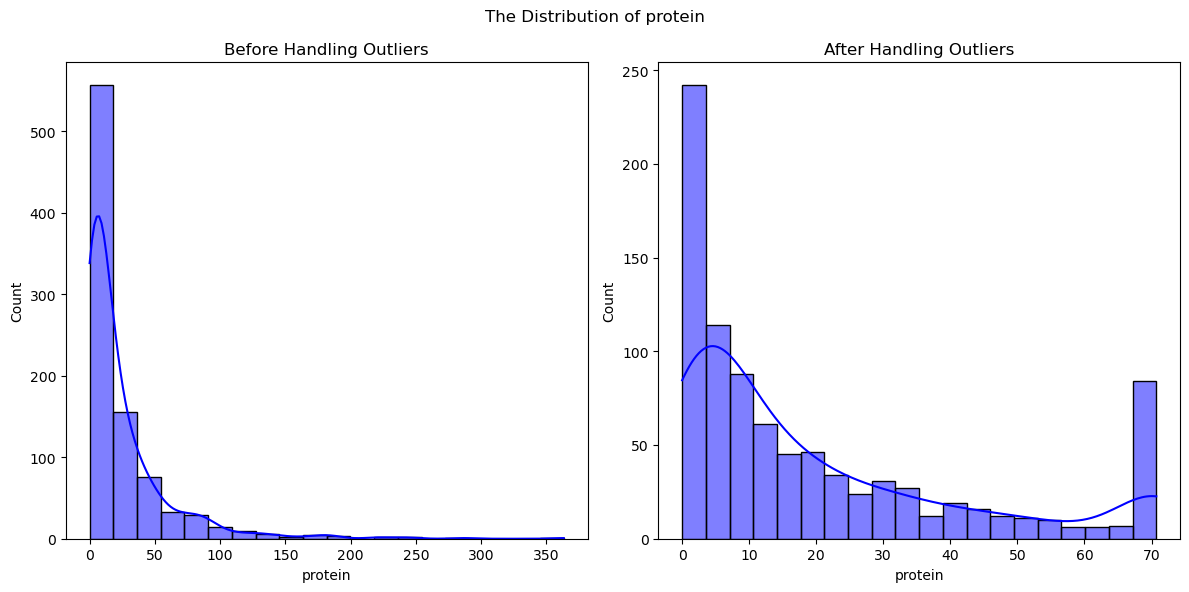

In [84]:
data_num = data.select_dtypes(include = ["float64", "int64"])
for col in data_num.columns:
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))
  sns.histplot(data_bef[col], kde=True, color='blue',ax=axes[0], bins=20)
  sns.histplot(data[col], kde=True, color='blue',ax=axes[1], bins=20)
  axes[0].set_title("Before Handling Outliers")
  axes[1].set_title("After Handling Outliers")
  fig.suptitle('The Distribution of '+col)
  plt.tight_layout()
  plt.show()

In [86]:
from scipy.stats import skew

# Select numerical columns
data_num = data.select_dtypes(include=["float64", "int64"])

# Create a dictionary to store skewness values
skewness_comparison = {}

print("\nSkewness Before and After Handling Outliers:\n")

# Iterate over each numeric column
for col in data_num.columns:
    skew_before = skew(data_bef[col].dropna())  # Skewness before outlier handling
    skew_after = skew(data[col].dropna())  # Skewness after outlier handling
    
    # Store results in dictionary
    skewness_comparison[col] = {"Before": skew_before, "After": skew_after}
    
    # Print results
    print(f"{col}:")
    print(f"  Before: {skew_before:.2f}")
    print(f"  After:  {skew_after:.2f}\n")

# Convert to DataFrame for easier analysis
skewness_df = pd.DataFrame.from_dict(skewness_comparison, orient="index")

# Display the skewness comparison
from IPython.display import display

display(skewness_df)  # Works in Jupyter Notebooks



Skewness Before and After Handling Outliers:

calories:
  Before: 2.03
  After:  1.08

carbohydrate:
  Before: 3.75
  After:  1.12

sugar:
  Before: 4.22
  After:  1.13

protein:
  Before: 3.50
  After:  1.20



,Before,After
calories,2.032737,1.078147
carbohydrate,3.750681,1.115597
sugar,4.216271,1.134569
protein,3.503568,1.204692


### 3.2: Basic Shape and Characteristics of the Data, revisited
After completing the operations above, I wanted to run the same functions as in the beginning, to understand the current state.

In [92]:
# Step 1: Inspect the dataset
print("Initial Dataset Overview:\n")
print(data.head())
print("\nDataset Info:\n")
print(data.info())
print("\nDataset Description (Numerical Columns):\n")
print(data.describe())
print("\nDataset Shape):\n")
print(data.shape)
print("\nDataset Types):\n")

Initial Dataset Overview:

        calories  carbohydrate   sugar  protein       category servings  \
recipe                                                                    
2          35.48         38.56   0.660     0.92         Potato        4   
3         914.28         42.68   3.090     2.88      Breakfast        1   
4          97.03         30.56  21.965     0.02      Beverages        4   
5          27.05          1.85   0.800     0.53      Beverages        4   
6         691.15          3.46   1.650    53.93  One Dish Meal        2   

         traffic  
recipe            
2           High  
3       Not_High  
4           High  
5       Not_High  
6           High  

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
Index: 895 entries, 2 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      895 non-null    float64 
 1   carbohydrate  895 non-null    float64 
 2   sugar         895 

### 3.2: Defining and Examining the Target Variable
Since the target variable of this exercise is obviously traffic, I wanted to obtain the counts and visualize the distribution in a histogram. The split is 59.8% High and 40.2% Not High.

In [51]:
value_counts = data['traffic'].value_counts()
percentage = (value_counts / value_counts.sum()) * 100
print(percentage)

traffic
High        59.776536
Not_High    40.223464
Name: count, dtype: float64


Text(0, 0.5, 'Count')

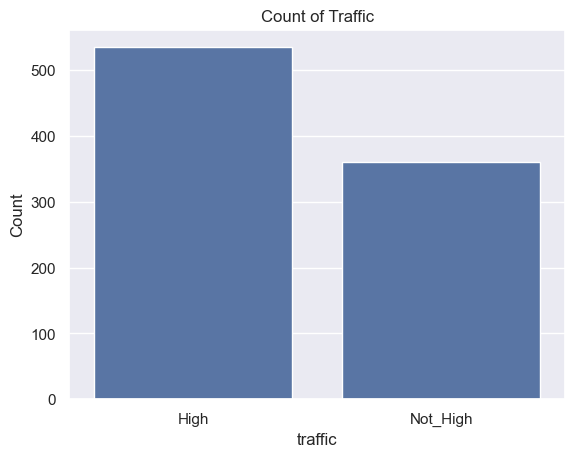

In [53]:
cou=sns.countplot(x='traffic', data=data) 
cou.set_title('Count of Traffic')
plt.ylabel('Count')

/var/folders/t_/9vw_fmpj34zg0gvg17yfgbdw0000gn/T/ipykernel_48219/459676.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  cou = sns.countplot(x='traffic', data=data, palette={'High': 'green', 'Not_High': 'red'})


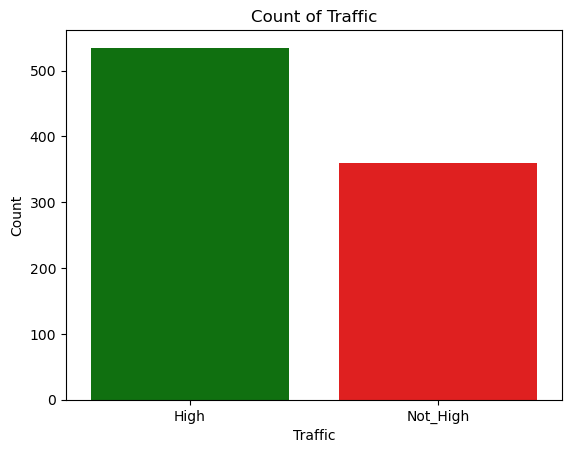

In [105]:
cou = sns.countplot(x='traffic', data=data, palette={'High': 'green', 'Not_High': 'red'}) 
cou.set_title('Count of Traffic')
plt.ylabel('Count')
plt.xlabel('Traffic')
plt.show()

### 3.3: Exploratory Analysis of Other Variables
Looking at the numeric variables, I chose to create a heat map to better understand any relationships or correlations between them. The heat map reveals that there are no strong correlations (above 0.5) between any of these variables. The highest correlation is between calories and protein (0.2), which is still weak. The lack of strong relationships suggests that each of these variables contributes independently to recipe characteristics, rather than being directly linked.

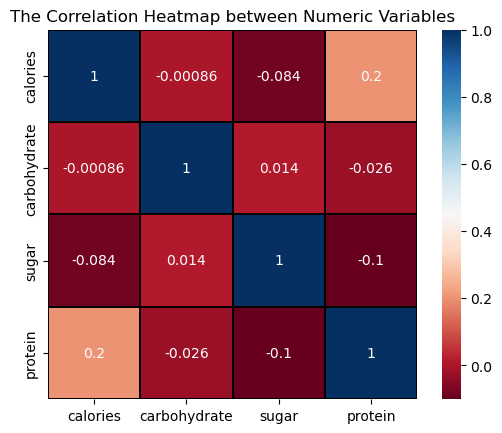

In [99]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
heat = sns.heatmap(correlation_matrix, annot=True, linewidth=0.01, square=True, cmap="RdBu", linecolor="black")
heat.set_title("The Correlation Heatmap between Numeric Variables")
plt.show()


### 3.4: Exploratory Analysis of the Relationship Between the Target Variable and Numeric Variables
I used bar plots to understand to the relationship within each numeric variable between high and low traffic. None of these showed any dramatic results, but it was interesting that recipes lower in sugar were majority 'Not_High.' I made High traffic green since it is the target variable, and Not_High red.<br>

High Traffic was seen more than Not_High in recipes with higher levels of calories, more carbohydrates, and more protein.<br>

I performed another visualization consisting of a pair plot (scatterplot matrix) using Seaborn to visualize the relationships between all numeric variables in the dataset while distinguishing between High Traffic (blue) and Not_High (orange).<br>

This visualization revealed that no single numerical feature of the dataset is a strong predictor of high traffic. Again, it showed that all distributions are right-skewed, meaning most recipes have low values, though some outliers still exist. Overlapping scatter points suggest high and low traffic recipes exist across all numerical feature ranges.

/var/folders/t_/9vw_fmpj34zg0gvg17yfgbdw0000gn/T/ipykernel_61687/542946816.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(
/var/folders/t_/9vw_fmpj34zg0gvg17yfgbdw0000gn/T/ipykernel_61687/542946816.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar.set_xticklabels([custom_labels[label] for label in data["traffic"].unique()])


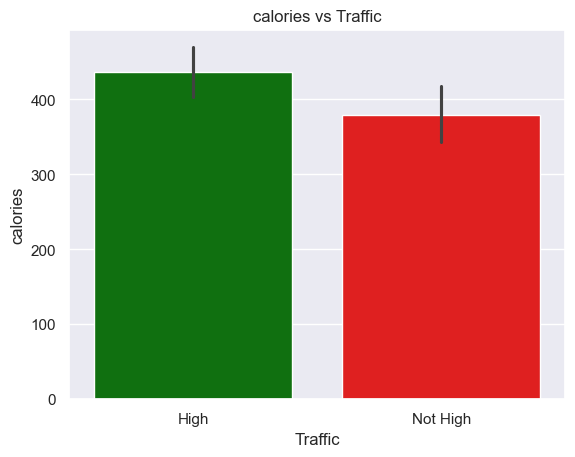

/var/folders/t_/9vw_fmpj34zg0gvg17yfgbdw0000gn/T/ipykernel_61687/542946816.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(
/var/folders/t_/9vw_fmpj34zg0gvg17yfgbdw0000gn/T/ipykernel_61687/542946816.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar.set_xticklabels([custom_labels[label] for label in data["traffic"].unique()])


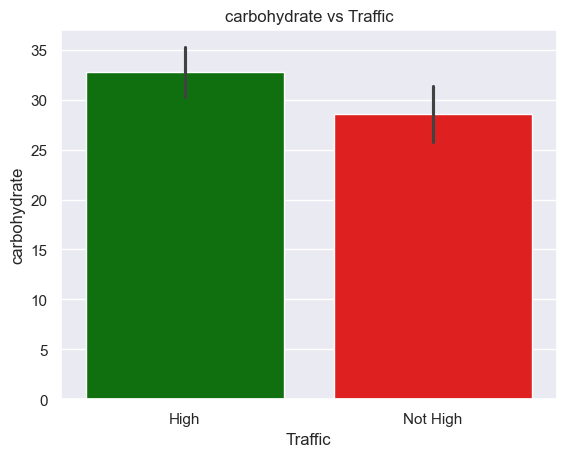

/var/folders/t_/9vw_fmpj34zg0gvg17yfgbdw0000gn/T/ipykernel_61687/542946816.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(
/var/folders/t_/9vw_fmpj34zg0gvg17yfgbdw0000gn/T/ipykernel_61687/542946816.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar.set_xticklabels([custom_labels[label] for label in data["traffic"].unique()])


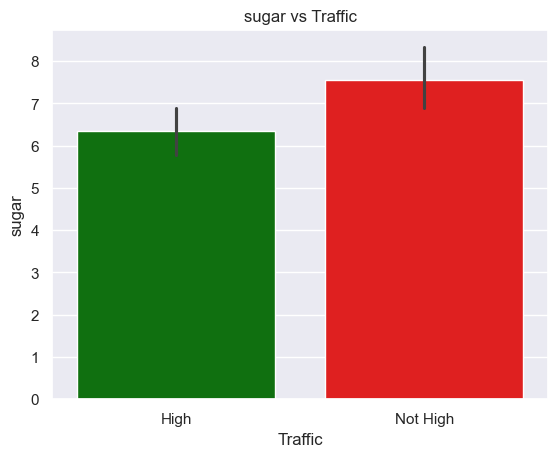

/var/folders/t_/9vw_fmpj34zg0gvg17yfgbdw0000gn/T/ipykernel_61687/542946816.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(
/var/folders/t_/9vw_fmpj34zg0gvg17yfgbdw0000gn/T/ipykernel_61687/542946816.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bar.set_xticklabels([custom_labels[label] for label in data["traffic"].unique()])


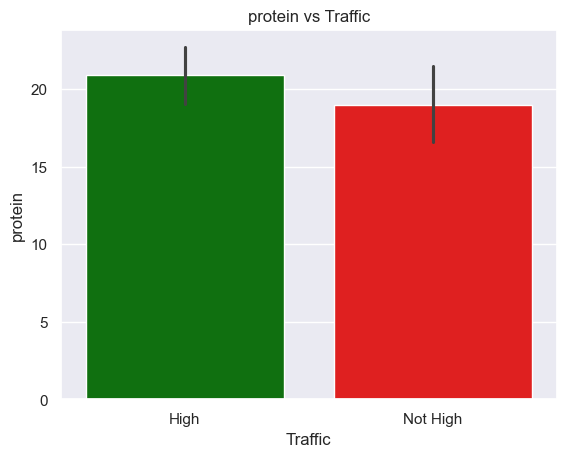

In [61]:
# Set custom labels for "High" and "Not High"
custom_labels = {"High": "High", "Not_High": "Not High"}

# Iterate over numeric columns and create bar plots
for col in data_num.columns:
    bar = sns.barplot(
        data=data, 
        x="traffic", 
        y=col, 
        hue=None,  # No hue is needed here unless required
        palette={"High": "green", "Not_High": "red"}  # Optional: color coding
    )
    # Set the custom labels
    bar.set(
        xlabel="Traffic", 
        ylabel=col, 
        title=f'{col} vs Traffic'
    )
    # Update xticklabels with custom labels
    bar.set_xticklabels([custom_labels[label] for label in data["traffic"].unique()])
    plt.show()



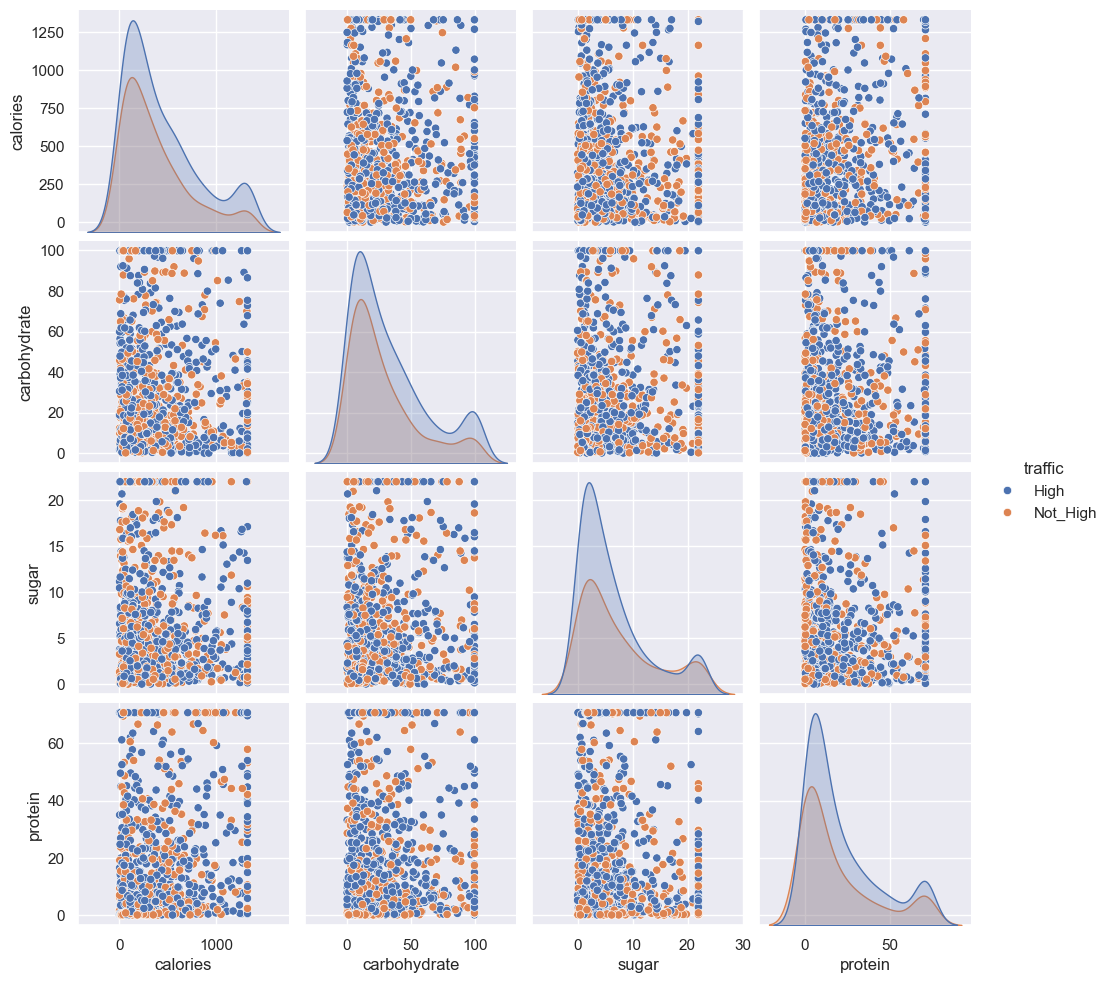

In [63]:
pair_plot = sns.pairplot(data=data, hue="traffic")
plt.show()

### 3.5: Exploratory Analysis of the Categorical Variables
I used bar plots to visualize the categorical variables.<br>

There are quite a few more four serving recipes than other categories in 'servings.' The most common recipes are for Breakfast, while the least common recipe category is 'One Dish Meal.'<br>

To further examine whether recipe category and serving size significantly impact traffic levels, I used the Chi-Square test of independence- since both category and servings are categorical variables, and traffic is also categorical.<br> 

The Recipe Category vs. Traffic test revealed that the recipe category significantly impacts traffic levels.
Since the p-value is < 0.05, we reject the null hypothesis. This means that some recipe categories are more likely to generate high traffic than others. The high Chi-Square value suggests that traffic distribution is not random across categories, indicating a strong relationship.<br>

The Servings vs. Traffic test revealed that no significant relationship exists between servings and traffic. Since the p-value is > 0.05, we fail to reject the null hypothesis. This means serving size does not appear to influence whether a recipe gets high traffic.
The low Chi-Square value suggests that traffic levels are evenly distributed across different serving sizes, meaning there’s no meaningful pattern.

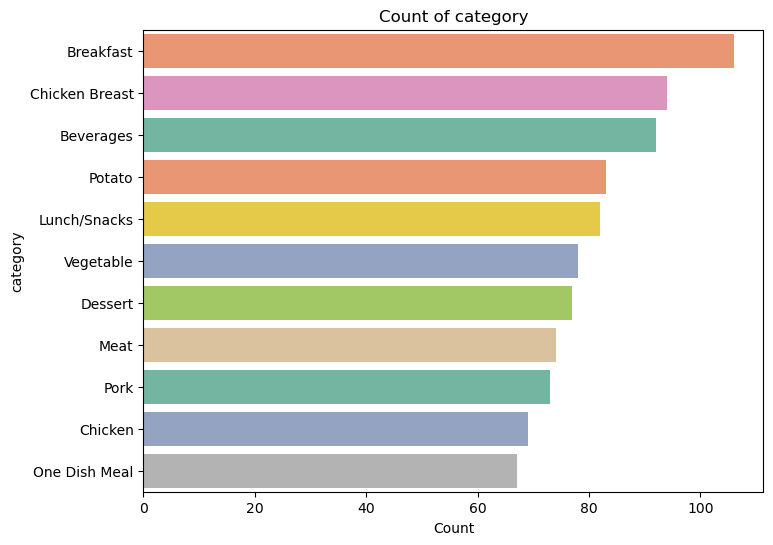

/var/folders/t_/9vw_fmpj34zg0gvg17yfgbdw0000gn/T/ipykernel_48219/4022327945.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  cou = sns.countplot(x='servings', data=data, palette="Set2")


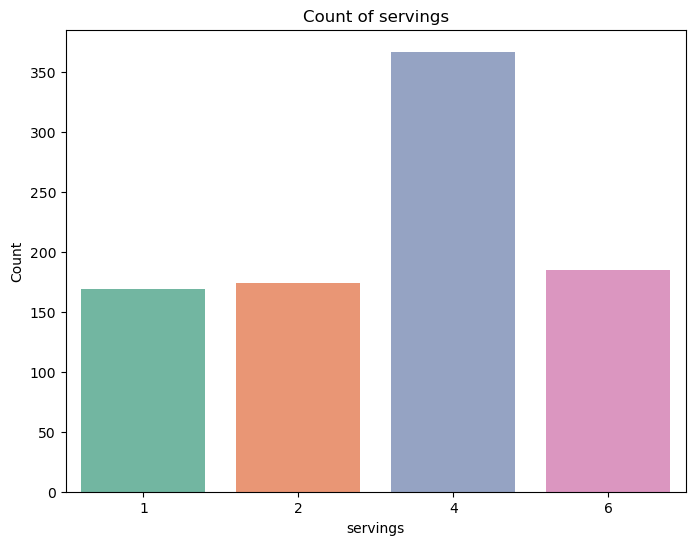

In [113]:
# Plot count of categories with hue set to 'category'
plt.figure(figsize=(8, 6))
cou = sns.countplot(
    y='category',
    data=data,
    order=data['category'].value_counts().index,
    hue='category',
    palette="Set2"
)
cou.set_title('Count of category')
plt.xlabel('Count')
plt.legend([], [], frameon=False)  # Remove legend
plt.show()

# Plot count of servings (hue is optional here)
plt.figure(figsize=(8, 6))
cou = sns.countplot(x='servings', data=data, palette="Set2")
cou.set_title('Count of servings')
plt.ylabel('Count')
plt.show()


### 3.6: Distribution of the Target Variable across the Categorical Variables
I used bar plots to visualize how traffic levels ("High" vs "Not_High") are distributed across different categories (of recipe) and servings.<br>

This was a revealing visualization. It shows that Recipe category is likely a strong predictor of traffic. Some categories such as Pork, Potato, and Vegetable have much more High Traffic recipes. Serving size might also have an impact, but the pattern is less clear than with category.

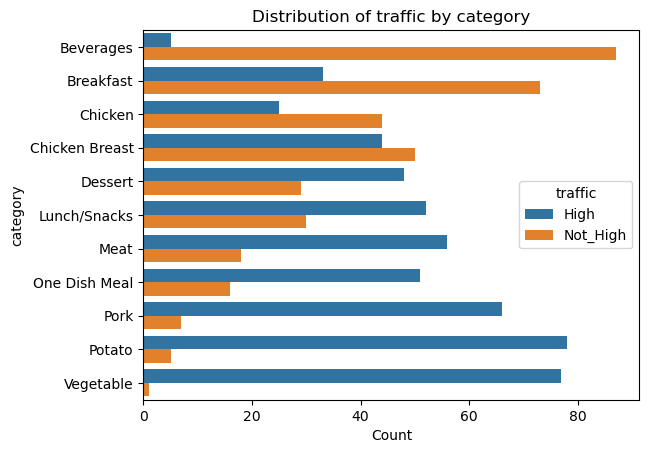

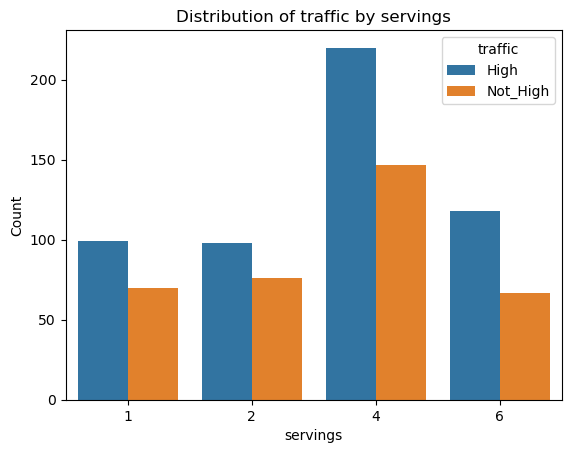

In [117]:
cou=sns.countplot(data=data, y="category", hue="traffic")
cou.set_title('Distribution of traffic by category')
plt.xlabel('Count')
plt.show()
cou=sns.countplot(x='servings', data=data, hue="traffic")
cou.set_title('Distribution of traffic by servings')
plt.ylabel('Count')
plt.show()

In [119]:
import scipy.stats as stats
import pandas as pd

# Create a contingency table (cross-tabulation of category vs. traffic)
category_contingency = pd.crosstab(data["category"], data["traffic"])

# Perform the Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(category_contingency)

# Print the results
print("\nChi-Square Test for Recipe Category vs. Traffic:")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-value: {p:.5f}")

# Interpret the results
alpha = 0.05  # Significance level
if p < alpha:
    print("Conclusion: Recipe category significantly impacts traffic levels (reject null hypothesis).")
else:
    print("Conclusion: No significant relationship between recipe category and traffic (fail to reject null hypothesis).")



Chi-Square Test for Recipe Category vs. Traffic:
Chi-Square Statistic: 305.59
P-value: 0.00000
Conclusion: Recipe category significantly impacts traffic levels (reject null hypothesis).


In [121]:
# Create a contingency table (cross-tabulation of servings vs. traffic)
servings_contingency = pd.crosstab(data["servings"], data["traffic"])

# Perform the Chi-Square test
chi2, p, dof, expected = stats.chi2_contingency(servings_contingency)

# Print the results
print("\nChi-Square Test for Servings vs. Traffic:")
print(f"Chi-Square Statistic: {chi2:.2f}")
print(f"P-value: {p:.5f}")

# Interpret the results
if p < alpha:
    print("Conclusion: Number of servings significantly impacts traffic levels (reject null hypothesis).")
else:
    print("Conclusion: No significant relationship between servings and traffic (fail to reject null hypothesis).")



Chi-Square Test for Servings vs. Traffic:
Chi-Square Statistic: 2.20
P-value: 0.53112
Conclusion: No significant relationship between servings and traffic (fail to reject null hypothesis).


# 4.0 Model Fitting


## 4.1 Problem Type

To predict 'High' or 'Not_High' traffic levels is a **binary classification type problem** in machine learning. 

For the first technique, a **Logistic Regression** model is used. Logistic Regression is commonly used for binary classification type problems.

For the second technique, a **Random Forest** model is used. Random Forest is an ensemble algorithm that utilizes multiple decision trees (the forest), and protects against overfitting while offering higher accuracy and robustness compared to a lone Decision Tree.

In [128]:
#Loading the necessary packages
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## 4.2 Data Preparation

In order to get the data ready for the model, I convert categorical data into numeric format (One-hot encoding for category, Label encoding for traffic) in order to ensure all variables are numerical and therefore machine-readable for the models. I added a new feature standard deviation (std) to capture variability. <br>

I used **calories, carbohydrate, sugar, protein, servings, category** as features. I scaled and standardized these. <br>

**Traffic** is the target variable.<br>

I also did a 80/20 train-test split to structure the dataset for training (X as features, y as target).<br>

In [80]:
data = pd.get_dummies(data, columns=['category'])

In [82]:
data['servings'] = data['servings'].astype('int')
label_encoder = LabelEncoder()
data['traffic'] = label_encoder.fit_transform(data['traffic'])

In [85]:
columns_to_std = ['calories','carbohydrate', 'sugar', 'protein']

# Calculate standard deviation for the selected columns and add a new 'std' column
data['std'] = data[columns_to_std].apply(lambda row: np.std(row), axis=1)

In [87]:
column_order = ['calories',  'carbohydrate',   'sugar',  'protein','std' , 'servings','category_Beverages'  ,'category_Breakfast' , 'category_Chicken' ,'category_Chicken Breast',  'category_Dessert' , 'category_Lunch/Snacks' ,'category_Meat',  'category_One Dish Meal',  'category_Pork',  'category_Potato', 'category_Vegetable' ,'traffic'] 
data = data[column_order]
data.head()

,calories,carbohydrate,sugar,protein,std,servings,category_Beverages,category_Breakfast,category_Chicken,category_Chicken Breast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,traffic
recipe,,,,,,,,,,,,,,,,,,
2,35.48,38.56,0.660,0.92,18.147933,4,False,False,False,False,False,False,False,False,False,True,False,0
3,914.28,42.68,3.090,2.88,389.210353,1,False,True,False,False,False,False,False,False,False,False,False,1
4,97.03,30.56,21.965,0.02,36.187104,4,True,False,False,False,False,False,False,False,False,False,False,0
5,27.05,1.85,0.800,0.53,11.264798,4,True,False,False,False,False,False,False,False,False,False,False,1
6,691.15,3.46,1.650,53.93,291.511236,2,False,False,False,False,False,False,False,True,False,False,False,0


In [90]:
# Define X variables and our target(y)
X = data.drop(["traffic"],axis=1).values
y = data["traffic"].values
print("X : ",X.shape," y : ",y.shape)

X :  (895, 17)  y :  (895,)


In [92]:
numeric_features = X[:, :5]

In [94]:
# Standardization
st_scaler = StandardScaler()
st_scaler.fit(numeric_features)
numeric_features_scaler = st_scaler.transform(numeric_features)

In [96]:
X_scaler = np.concatenate((numeric_features_scaler, X[:, 5:]), axis=1)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_scaler,
              y, test_size= 0.20, random_state=10)

In [101]:
print("X_train = ",X_train.shape ," y_train = ", y_train.shape)
print("X_test  = ",X_test.shape ," y_test = ", y_test.shape)

X_train =  (716, 17)  y_train =  (716,)
X_test  =  (179, 17)  y_test =  (179,)


## 4.3 Fitting a Baseline Model - Logistic Regression

This code performs Logistic Regression modeling, evaluates its performance using classification metrics, and visualizes feature importance to understand which variables impact the prediction of high-traffic recipes.

In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report

logistic_model = LogisticRegression(max_iter=1000, C=5)
logistic_model.fit(X_train, y_train)
y_pred = logistic_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[105  12]
 [ 22  40]]
Classification report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       117
           1       0.77      0.65      0.70        62

    accuracy                           0.81       179
   macro avg       0.80      0.77      0.78       179
weighted avg       0.81      0.81      0.81       179



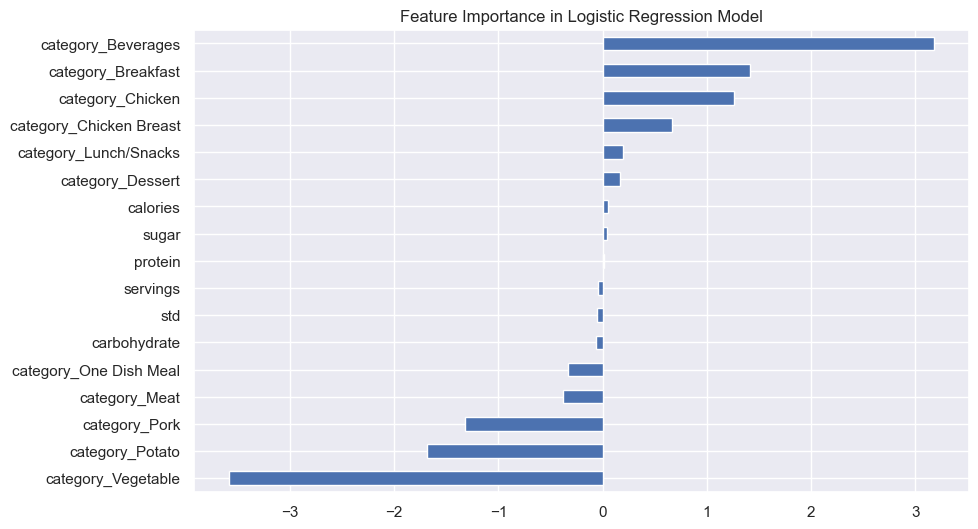

In [108]:
# Feature Importance
importances = pd.Series(logistic_model.coef_[0],index=column_order[:-1])
sorted_importances=importances.sort_values()
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='barh')
plt.title('Feature Importance in Logistic Regression Model')
plt.show()

## 4.3 Fitting a Comparison Model - Random Forest

This code performs Random Forest modeling, evaluates its performance using classification metrics, and visualizes feature importance to understand which variables impact the prediction of high-traffic recipes.

In [111]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report

random_forest_model = RandomForestClassifier(n_estimators=10,max_depth=10,min_samples_split=3, random_state=42)
random_forest_model.fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[106  11]
 [ 16  46]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       117
           1       0.81      0.74      0.77        62

    accuracy                           0.85       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.85      0.85      0.85       179



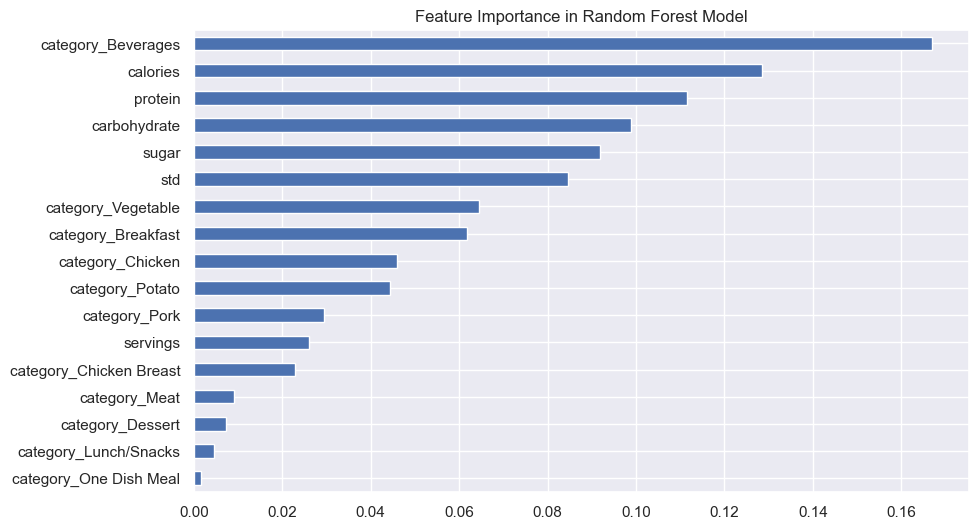

In [113]:
# Feature Importance
importances = pd.Series(random_forest_model.feature_importances_,index=column_order[:-1])
sorted_importances=importances.sort_values()
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='barh')
plt.title('Feature Importance in Random Forest Model')
plt.show()

# 5.0 Model Evaluation

Both models were trained to predict high-traffic recipes, but they exhibit different levels of accuracy, recall, and interoperability.
<br><br>
Logistic Regression achieved an accuracy of 81%, with a recall of 0.65 for high-traffic recipes. This means that while it correctly identifies high-traffic recipes 65% of the time, it has a higher chance of missing some.
<br><br>
Random Forest, on the other hand, performed better overall with an accuracy of 85% and a recall of 0.74 for high-traffic recipes, indicating that it captures more high-traffic recipes correctly than Logistic Regression.
<br><br>
The precision for high-traffic recipes is slightly higher in Logistic Regression (0.77) than Random Forest (0.81), but Random Forest balances precision and recall better, making it a stronger candidate.


## 5.1 Feature Importance
A key difference between these models is how they weigh feature importance:
<br><br>
Logistic Regression places the highest importance on specific recipe categories, particularly Beverages, Breakfast, and Chicken. This suggests that these categories strongly influence whether a recipe is high-traffic.
<br><br>
Random Forest, however, considers nutritional content (calories, protein, carbohydrate, and sugar) as more important, alongside category features like Beverages and Vegetables. This indicates that it finds a deeper relationship between both categorical and continuous variables, making it a more robust predictor.
<br><br>
Random Forest is the better-performing model, achieving a higher recall (0.74 vs. 0.65) and overall accuracy (85% vs. 81%).
Logistic Regression provides clear interpretability, particularly showing that certain recipe categories have the strongest impact on traffic.
<br><br>
Random Forest is more flexible, incorporating nutritional values as key predictors while also considering categorical effects.
For deployment, Random Forest would likely provide more reliable recommendations, but if explainability is critical, Logistic Regression could still be used as a secondary validation method.


# 6.0 Business Goals

## **The business goals**

asdfasdf There are two business goals:

    Predict recipes with high traffic.

    Achieve an 80% probability of predicting 'High' traffic for recipes.

The Random Forest model has achieved both goals, because it has high rates of Precision, Recall and F1 Score are more then 80%.
Recommendations

To help Product Manager predict the high traffic of the recipes, we can deploy this Random Forest Model into production. By implementing this model, about 89% of the prediction will make sure the traffic will be high. This will help Product Manager build their confidence in generating more traffic to the rest of the website.

To implement and improve the model, I will consider the following steps:

    Deployment Strategy: Explore optimal deployment strategies for the machine learning model in terms of performance and cost-effectiveness. Consider deploying it on edge devices for convenience and security, and test the model with newly hired product analysts.
    Regular Model Retraining: Implement a system for regular model retraining. As user preferences may change over time, it is essential to keep the model up-to-date with the latest data to maintain its predictive accuracy.
    Collect More Data: e.g. time to make, cost per serving, ingredients, site duration time (how long users were at the recipe page), income links (from what sites users came to the recipe page), combinations of recipes (what recipes user visited at the same session with the current recipe).
    Balance Data Categories: The dataset contains a class imbalance between low and high-traffic recipes. To address this issue, we suggest collecting additional data for the minority class (low-traffic recipes) or applying data augmentation techniques to balance the dataset.

PI and the performance of 2 models using KPI

The company wants to increase an accuracy of prediction of high traffic. Therefore, we would consider using accuracy of predictions which predicted high traffic as a KPI to compare 2 models again. The higher the percentage, the better the model performs. The Logistic Regression model has an accuracy lower than 80%, while the Random Forest model achieves approximately 85% accuracy.


In [161]:
# accuracy score on the train data
X_train_pred = logistic_model.predict(X_train)
print('Accuracy score of the train data: ', accuracy_score(X_train_pred, y_train))

# accuracy score on the test data
X_test_pred = logistic_model.predict(X_test)
print('Accuracy score of the test data: ', accuracy_score(X_test_pred, y_test))

Accuracy score of the train data:  0.7486033519553073
Accuracy score of the test data:  0.8100558659217877


In [163]:
# accuracy score on the train data
X_train_pred = random_forest_model.predict(X_train)
print('Accuracy score of the train data: ', accuracy_score(X_train_pred, y_train))

# accuracy score on the test data
X_test_pred = random_forest_model.predict(X_test)
print('Accuracy score of the test data: ', accuracy_score(X_test_pred, y_test))

Accuracy score of the train data:  0.8645251396648045
Accuracy score of the test data:  0.8491620111731844


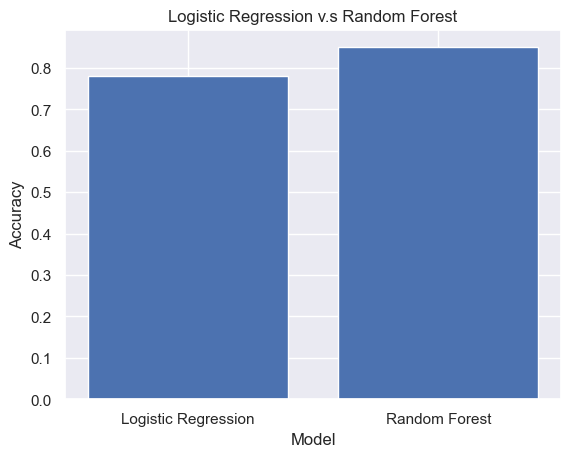

In [165]:
model1_accuracy =  0.78
model2_accuracy = 0.85

model_names = ['Logistic Regression', 'Random Forest']
x = range(len(model_names))
accuracies = [model1_accuracy, model2_accuracy]
plt.bar(x, accuracies, tick_label=model_names)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Logistic Regression v.s Random Forest')
plt.show()

asdfsadf 7. Conclusion

Predicting popular recipes for the homepage is a valuable step toward achieving the company's business goals. Our machine learning models offer a data-driven approach that can significantly improve the recipe selection process. By tracking the suggested KPI and implementing our recommendations, we can expect to see positive results in terms of website traffic and subscriptions.